In [1]:
import pandas as pd
import rdkit
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.featurizer import MordredFeaturizer

In [2]:
# Load the dataset

df = '../data/herg/herg_central.csv'
df = pd.read_csv(df)
df.head()

,ID,X,hERG_at_1uM,hERG_at_10uM,hERG_inhib
0,22416348,Cc1occc1C(=O)NCc1ccco1,20.17528,30.99165,0
1,26665387,COc1ccc(/C=C2\SC(=S)N(N3CCOCC3)C2=O)c(OC)c1,10.22630,13.05888,0
2,862531,C[C@H](NC(=O)Nc1cccc(C(F)(F)F)c1)C(=O)O,2.04420,0.06288,0
3,26732361,COc1cc(OC)c2ccc(=O)oc2c1C(CC(=O)N1CCOCC1)c1ccc...,21.80250,17.87858,0
4,49735227,COc1cccc(NC(=O)C2C3C=CC4(O3)C2C(=O)N(CCCN2CCCC...,8.33980,19.03128,0


In [3]:
# classify molecules by BBB permeability

from src.featurizer.featurizer import EcfpFeaturizer, MordredFeaturizer
from src.predictor.scikit import SvmClassifier, RfClassifier, PredictorBase

MODEL_PATH = '../models/RF_ECFP_BBBP_PAMPA/model.pkl'

# Init featurizer and model
featurizer = MordredFeaturizer()
model = RfClassifier(target_metric='roc_auc', optimize_hyperparameters=True, optimization_iterations=10, n_folds=5, n_jobs=8)
model.load(MODEL_PATH)
model.inject_featurizer(featurizer)

In [ ]:
smiles_list = df['X'].tolist()
X = featurizer.featurize(smiles_list)

In [5]:
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425
0,1.0,1.0,34.307009,2.649199,5.079610,34.307009,1.319500,4.259065,0.0,3.698543,...,10.575437,83.166749,367.133907,7.648623,1679.0,43.0,152.0,189.0,7.833333,5.416667
1,0.0,1.0,37.110215,2.647964,5.033911,37.110215,1.374452,4.309684,0.0,3.635367,...,10.587972,84.777487,363.183444,6.984297,1896.0,43.0,160.0,200.0,5.972222,5.666667
2,0.0,0.0,38.254689,2.506546,4.976973,38.254689,1.319127,4.352296,0.0,4.686829,...,10.546315,85.605679,397.196569,7.355492,2510.0,48.0,166.0,202.0,8.673611,6.041667
3,0.0,1.0,34.380514,2.514342,5.010767,34.380514,1.322327,4.239077,0.0,4.692696,...,10.580023,75.735634,353.179107,7.063582,1670.0,42.0,150.0,183.0,6.701389,5.472222
4,0.0,2.0,36.439335,2.648997,5.134526,36.439335,1.349605,4.317265,0.0,3.772661,...,10.717413,84.719400,360.220164,6.549458,1881.0,42.0,162.0,202.0,6.062500,5.611111


In [26]:
predictions = model.predict(smiles_list)
df['BBBP_prediction'] = predictions

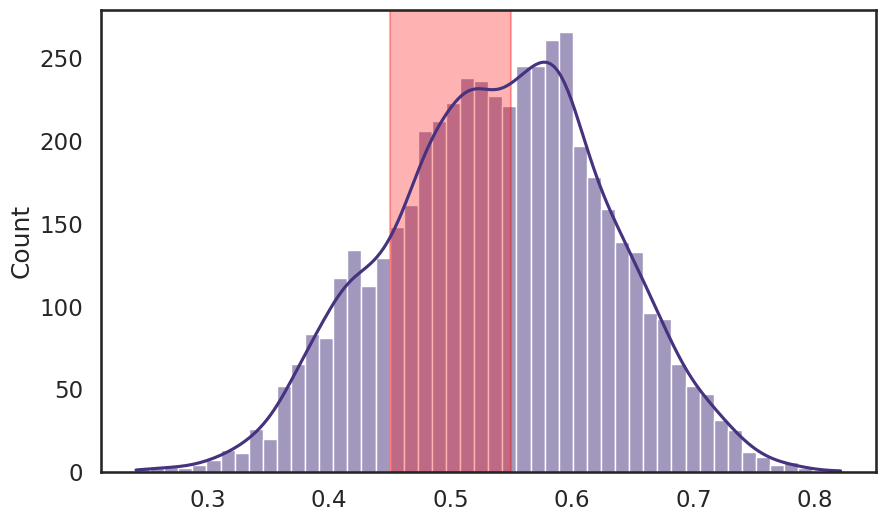

In [28]:
sns.set_style(style="white")
sns.set_context("talk")
sns.set_palette("viridis")
plt.figure(figsize=(10, 6))
sns.histplot(predictions, bins=50, kde=True)
plt.axvspan(0.45, 0.55, color='red', alpha=0.3)

In [29]:
# draw top 10 molecules with highest predicted probability of being BBB permeable
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from ipywidgets import interact, widgets
from rdkit.Chem.Draw import rdMolDraw2D

top_100 = df.nlargest(100, 'BBBP_prediction')

#interactive widget to draw top molecules

@interact
def draw_top_molecules(i=widgets.IntSlider(min=0, max=90, step=10)):
    mols = [Chem.MolFromSmiles(smi) for smi in top_100['molecule']][i:i+10]
    [rdDepictor.Compute2DCoords(mol) for mol in mols if mol is not None]  # Ensure 2D coordinates are computed
    [rdDepictor.StraightenDepiction(mol) for mol in mols if mol is not None]  # Straighten depiction
    legends = [str(x) for x in top_100['BBBP_prediction'].round(2).tolist()][i:i+10]
    return Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), useSVG=True, legends=legends)

interactive(children=(IntSlider(value=0, description='i', max=90, step=10), Output()), _dom_classes=('widget-i…

In [30]:
bottom_100 = df.nsmallest(100, 'BBBP_prediction')

@interact
def draw_top_molecules(i=widgets.IntSlider(min=0, max=90, step=10)):
    mols = [Chem.MolFromSmiles(smi) for smi in bottom_100['molecule']][i:i+10]
    [rdDepictor.Compute2DCoords(mol) for mol in mols if mol is not None]  # Ensure 2D coordinates are computed
    [rdDepictor.StraightenDepiction(mol) for mol in mols if mol is not None]  # Straighten depiction
    legends = [str(x) for x in bottom_100['BBBP_prediction'].round(2).tolist()][i:i+10]
    return Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), useSVG=True, legends=legends)

interactive(children=(IntSlider(value=0, description='i', max=90, step=10), Output()), _dom_classes=('widget-i…